In [1]:
# importing packages !
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize
from obspy.signal.rotate import rotate_ne_rt
from TransCFunctionsAlex import *

from obspy.clients.syngine import Client
client = Client()

from pyTransC import TransC_Sampler

import obspy
import pandas as pd
from datetime import datetime
from obspy.geodetics import gps2dist_azimuth
from obspy import Stream
#import UTCDateTime

from obspy.clients.fdsn import Client
ap = Client('IRIS')

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

# setting global parameter controls
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling
autopseudo = True    # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False     # Thin internally generated within state posterior ensembles by their auto-correlation 

In [2]:
# setting up the station inventory for UNGL
inv = ap.get_stations(network='*', station="UNGL", level='response', channel='LHZ,LHN,LHE', starttime=obspy.UTCDateTime(2016,1,1,1),
                      endtime = obspy.UTCDateTime(2020,1,1,1), maxlatitude=-63)
print(inv)

sta_lats = []
sta_lons = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        sta_lats.append(inv[i][j].latitude)
        sta_lons.append(inv[i][j].longitude)

print('Number of stations:', len(sta_lats))

# indexing the stations to a single variable

stations_flat = []
networks_flat = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        stations_flat.append(inv[i][j].code)
        networks_flat.append(inv[i].code)

print((stations_flat))
print(len(networks_flat))

bulk_stations = []

for i in range(len(sta_lats)):
    receiver_lat = sta_lats[i]
    receiver_lon = sta_lons[i]
    station_code = stations_flat[i]
    bulk_stations.append({"latitude": receiver_lat, "longitude": receiver_lon, "stationcode": station_code})

#print(bulk_stations)

son = pd.read_csv(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\Pham2025_submitted\TableS1.csv")
#son = son[son['quality_group'] == 'A'] # filtering to only the quality A events

lats = son['relocated_latitude'].tolist()
lons = son['relocated_longitude'].tolist()

det_lats = son['detected_latitude'].tolist()
det_lons = son['detected_longitude'].tolist()

mags = son['Ms_BB'].tolist()
times = son['relocated_time'].tolist()
qual_group = son['quality_group'].tolist()
ens = son['eff_nstations'].tolist()

#qualities = son['quality_group'].tolist()

son_date_format = '%Y-%m-%dT%H:%M:%S.000000Z'

years = []
months = []
days = []
for i in range(len(times)):
    years.append(int(datetime.strptime(times[i], son_date_format).strftime('%Y')))
    months.append(int(datetime.strptime(times[i], son_date_format).strftime('%m')))
    days.append(int(datetime.strptime(times[i], son_date_format).strftime('%d')))
    
# calculate the distance between two stations
def distance(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[0]

def back_azimuth(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[2]

# isolating the specific event
test = []

for i in range(len(times)):
    if times[i] == '2016-01-10T19:23:27.000000Z':
        test.append(i)
        event_lat = lats[i]
        event_lon = lons[i]
        event_time = times[i]
        event_mag = mags[i]
        event_year = years[i] + months[i]/12 + days[i]/365

for i in range(len(bulk_stations)):
    distancee = distance(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])/1000
    print(bulk_stations[i]['stationcode'], distancee)
    backaz = back_azimuth(event_lat, event_lon, bulk_stations[i]['latitude'], bulk_stations[i]['longitude'])
    print(bulk_stations[i]['stationcode'], backaz)
    print('---')
    
event_info = event_lat, event_lon, event_time

station_infos = [sta_lats, sta_lons, networks_flat, stations_flat]

station_info = []

for i in range(len(sta_lats)):
    station_inf = inv, networks_flat[i], stations_flat[i], sta_lats[i], sta_lons[i] 
    station_info.append(station_inf)
    
stations = stations_flat

Inventory created at 2025-10-18T16:34:50.519000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (1):
			YT.UNGL (Union Glacier)
		Channels (6):
			YT.UNGL..LHZ (2x), YT.UNGL..LHN (2x), YT.UNGL..LHE (2x)
Number of stations: 1
['UNGL']
1
UNGL 667.0597999650943
UNGL 305.76012460515807
---


In [3]:
real_signals, dist_infos, back_azs, begin_times, end_times, arrival_times = acquire_real_waveforms(station_infos, event_info, inv)

real_signals

3 Trace(s) in Stream:
YT.UNGL..LHE | 2016-01-10T19:20:34.000000Z - 2016-01-10T19:33:53.000000Z | 1.0 Hz, 800 samples
YT.UNGL..LHN | 2016-01-10T19:20:34.000000Z - 2016-01-10T19:33:53.000000Z | 1.0 Hz, 800 samples
YT.UNGL..LHZ | 2016-01-10T19:20:34.000000Z - 2016-01-10T19:33:53.000000Z | 1.0 Hz, 800 samples

In [4]:
p_real_signals, npts, delta = preprocessing_real_waveforms(real_signals)

for tr in p_real_signals:
    tr.trim(starttime=tr.stats.starttime, endtime=tr.stats.endtime - 1)
    
p_real_signals

3 Trace(s) in Stream:
YT.UNGL..LHT | 2016-01-10T19:24:43.000000Z - 2016-01-10T19:28:52.000000Z | 1.0 Hz, 250 samples
YT.UNGL..LHR | 2016-01-10T19:24:43.000000Z - 2016-01-10T19:28:52.000000Z | 1.0 Hz, 250 samples
YT.UNGL..LHZ | 2016-01-10T19:24:43.000000Z - 2016-01-10T19:28:52.000000Z | 1.0 Hz, 250 samples

In [5]:
ydatas, real_station_streams = setup_ydata(p_real_signals)
real_station_streams

[3 Trace(s) in Stream:
YT.UNGL..LHZ | 2016-01-10T19:24:43.000000Z - 2016-01-10T19:28:52.000000Z | 1.0 Hz, 250 samples
YT.UNGL..LHR | 2016-01-10T19:24:43.000000Z - 2016-01-10T19:28:52.000000Z | 1.0 Hz, 250 samples
YT.UNGL..LHT | 2016-01-10T19:24:43.000000Z - 2016-01-10T19:28:52.000000Z | 1.0 Hz, 250 samples]

In [6]:
# setting up the scaling factors for the elementary functions 
scaling_SF = np.array([1E9, 1E8, 1E9]) # Fr, Ft, Fp << matched from Son's for order of mag 
scaling_MT = np.array([1E13, 1E13, 1E13, 1E15, 1E15, 1E13]) # Mrr, Mtt, Mpp, Mrt, Mrp, Mtp << like 4 orders of magnitude larger

In [7]:
# finding the earliest and latest times to be gathering from
earliest_time = min(begin_times)
latest_time = max(end_times)

ttot = latest_time-earliest_time

starter_time = obspy.UTCDateTime(event_time) - earliest_time

# Using list comprehension - each arrival time repeated 3 times
arrival_times_expanded = [arrival_time for arrival_time in arrival_times for _ in range(3)]

coche = client.get_model_info(model_name='prem_a_10s')

time_info = [starter_time, ttot, arrival_times_expanded]

stations


['UNGL']

In [8]:
def SF_elementary_func(set):
    data = client.get_waveforms_bulk(
        model = 'prem_a_10s',
        bulk = bulk_stations,
        sourcelatitude = event_lat,
        sourcelongitude = event_lon,
        sourcedepthinmeters = 500,  # 500 m depth
        sourceforce = set*scaling_SF, # single force event - Fr, Ft, Fp
        origintime = obspy.UTCDateTime(event_time),
        starttime = -starter_time,
        endtime = ttot, 
        components = 'ZRT',
        units = 'displacement'
    )
    
    conv_data = convolution_function(data)
    
    conv_data.resample(1.0)

    for tr in conv_data:
        # correct for sign flip in the radial component
        if tr.stats.channel.endswith('R'): tr.data *= -1

    conv_data.detrend('demean')
    conv_data.detrend('linear')
    conv_data.taper(max_percentage=0.1)
    
    for i in range(len(conv_data)):
        conv_data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 4, zerophase = True) # ok looks like this happens post conv.
        conv_data[i].trim(starttime=arrival_times_expanded[i]-150, endtime=arrival_times_expanded[i]+100)
        #data[i].trim(starttime=data[i].stats.starttime + 200, endtime=data[i].stats.endtime - 200)
        
        # Ensure exactly 250 samples
        if len(conv_data[i].data) > 250:
            # Trim to first 250 samples
            conv_data[i].data = conv_data[i].data[:250]
            conv_data[i].stats.npts = 250
        elif len(conv_data[i].data) < 250:
            # Pad with zeros to reach 250 samples
            padding = np.zeros(250 - len(conv_data[i].data))
            conv_data[i].data = np.concatenate([conv_data[i].data, padding])
            conv_data[i].stats.npts = 250

        # # Update endtime to match new length
        # data[i].stats.endtime = data[i].stats.starttime + (399 / data[i].stats.sampling_rate)
    
    station_streems = []
    outputs = []
    # Fix: Extract station codes from trace stats, not the traces themselves
    for station in stations:
        station_streem = conv_data.select(station=station)
        if len(station_streem) == 3:
            station_streem = station_streem.select(component='Z') + \
                        station_streem.select(component='R') + \
                        station_streem.select(component='T')
            station_streems.append(station_streem)

            ydota = [station_streem[0].data, station_streem[1].data, station_streem[2].data]            
            outputs.append(ydota)

    return outputs

SF_e1 = SF_elementary_func(np.array([1, 0, 0])) # Fr
SF_e2 = SF_elementary_func(np.array([0, 1, 0])) # Ft
SF_e3 = SF_elementary_func(np.array([0, 0, 1])) # Fp

In [9]:
def MT_elementary_func(set):
    data = client.get_waveforms_bulk(
        model = 'prem_a_10s',
        bulk = bulk_stations,
        sourcelatitude = event_lat,
        sourcelongitude = event_lon,
        sourcedepthinmeters = 500,  # 500 m depth
        sourcemomenttensor = set*scaling_MT, # single force event - Mrr, Mtt, Mpp, Mrt, Mrp, Mtp
        origintime = obspy.UTCDateTime(event_time),
        starttime = -starter_time,
        endtime = ttot, 
        components = 'ZRT',
        units = 'displacement'
    )
    data.resample(1.0)
    data.detrend('demean')
    data.detrend('linear')
    data.taper(max_percentage=0.1)
    
    for i in range(len(data)): # no convolution required for MT sources apparently
        data[i].trim(starttime=arrival_times_expanded[i]-350, endtime=arrival_times_expanded[i]+300)
        data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 3, zerophase = True)
        data[i].trim(starttime=data[i].stats.starttime + 200, endtime=data[i].stats.endtime - 200)
        data[i].taper(max_percentage=0.15)
        
        # Ensure exactly 250 samples
        if len(data[i].data) > 250:
            # Trim to first 250 samples
            data[i].data = data[i].data[:250]
            data[i].stats.npts = 250
        elif len(data[i].data) < 250:
            # Pad with zeros to reach 250 samples
            padding = np.zeros(250 - len(data[i].data))
            data[i].data = np.concatenate([data[i].data, padding])
            data[i].stats.npts = 250

        # # Update endtime to match new length
        # data[i].stats.endtime = data[i].stats.starttime + (399 / data[i].stats.sampling_rate)
    
    station_streems = []
    outputs = []
    # Fix: Extract station codes from trace stats, not the traces themselves
    for station in stations:
        station_streem = data.select(station=station)
        if len(station_streem) == 3:
            station_streem = station_streem.select(component='Z') + \
                        station_streem.select(component='R') + \
                        station_streem.select(component='T')
            station_streems.append(station_streem)

            ydota = [station_streem[0].data, station_streem[1].data, station_streem[2].data]            
            outputs.append(ydota)

    return outputs

MT_e1 = MT_elementary_func(np.array([1, 0, 0, 0, 0, 0])) # Mrr
MT_e2 = MT_elementary_func(np.array([0, 1, 0, 0, 0, 0])) # Mtt
MT_e3 = MT_elementary_func(np.array([0, 0, 1, 0, 0, 0])) # Mpp
MT_e4 = MT_elementary_func(np.array([0, 0, 0, 1, 0, 0])) # Mrt
MT_e5 = MT_elementary_func(np.array([0, 0, 0, 0, 1, 0])) # Mrp
MT_e6 = MT_elementary_func(np.array([0, 0, 0, 0, 0, 1])) # Mtp

In [10]:
station_info

[(Inventory created at 2025-10-18T16:34:50.519000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (1):
			YT.UNGL (Union Glacier)
		Channels (6):
			YT.UNGL..LHZ (2x), YT.UNGL..LHN (2x), YT.UNGL..LHE (2x),
  'YT',
  'UNGL',
  -79.7746,
  -82.524)]

YT UNGL
Selected 263 out of 628 traces with amplitude < 4.57e-08 and exactly 250 samples
Selected 107 out of 628 traces with amplitude < 3.30e-08 and exactly 250 samples
Selected 92 out of 628 traces with amplitude < 2.38e-08 and exactly 250 samples
Selected 115 out of 628 traces with amplitude < 3.65e-08 and exactly 250 samples
Selected 241 out of 628 traces with amplitude < 5.42e-08 and exactly 250 samples


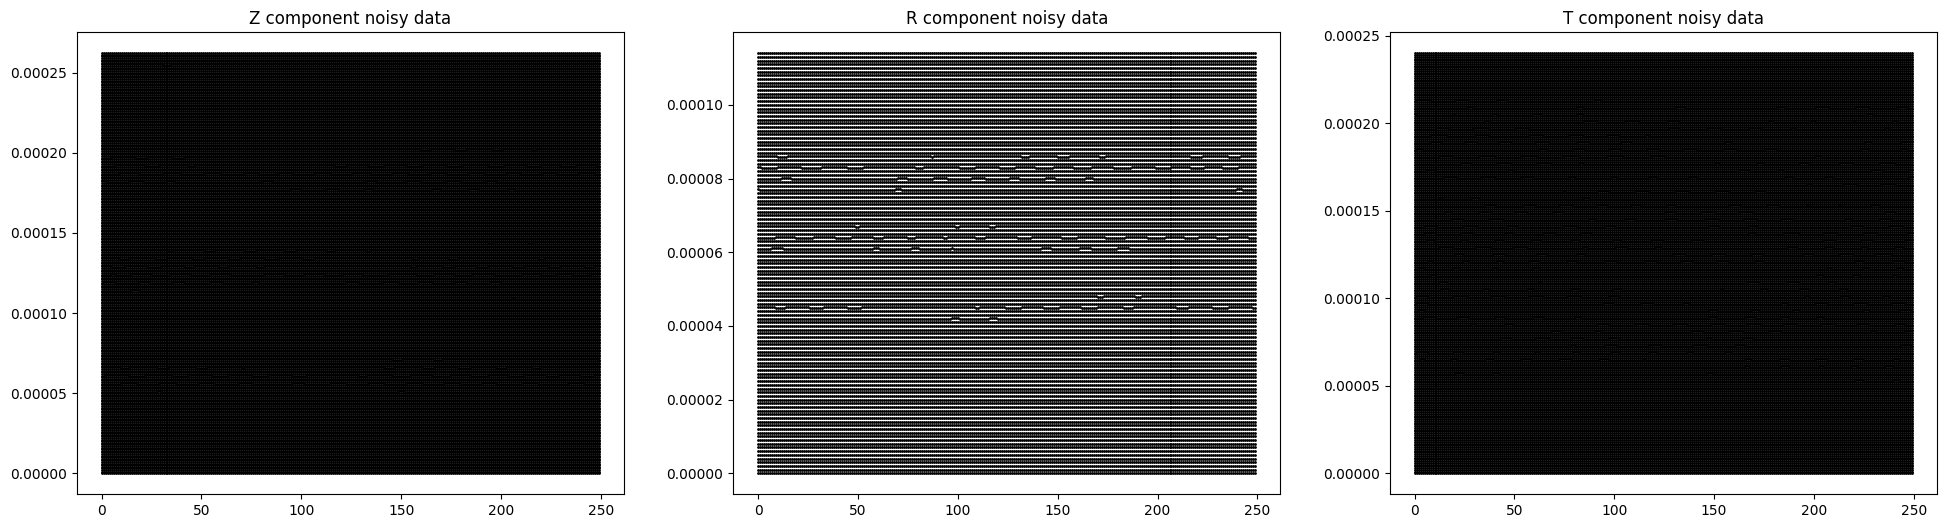

In [11]:
low_amps_z, low_amps_r, low_amps_t = [], [], []

noise_maxs_z = [25]
noise_maxs_r = [25]
noise_maxs_t = [25]

for i in range(len(sta_lats)):
    print(networks_flat[i], stations_flat[i])
    low_z, low_r, low_t, low_n, low_e = rsnss(station_info[i], event_info, sampling_start=60*60*2, slice_duration=650, overlap=600, sampling_length=60*60*9, 
                                                                   noise_max_z=noise_maxs_z[i], noise_max_r=noise_maxs_r[i], noise_max_t=noise_maxs_t[i])
    low_amps_z.append(low_z)
    low_amps_r.append(low_r)
    low_amps_t.append(low_t)

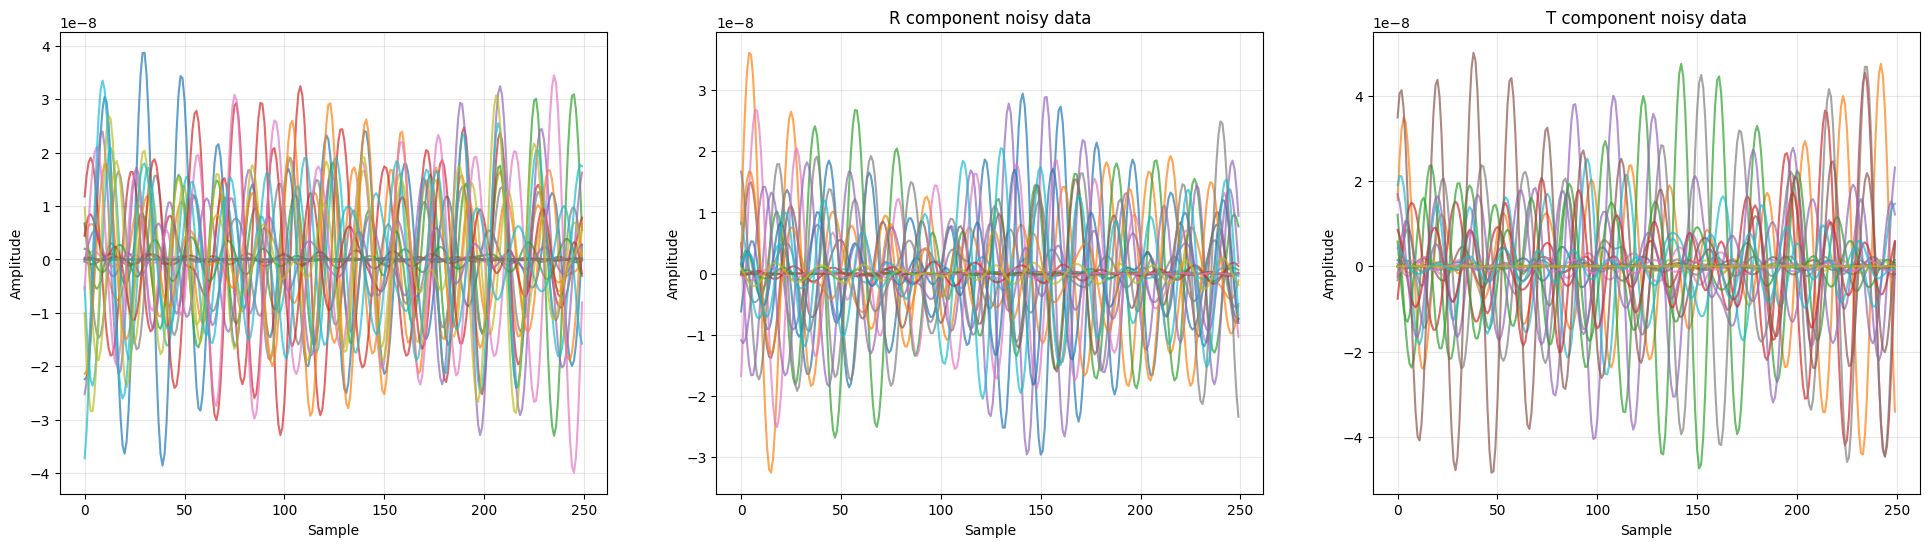

In [12]:
check_noise = random_noise_samples(low_amps_z, low_amps_r, low_amps_t)

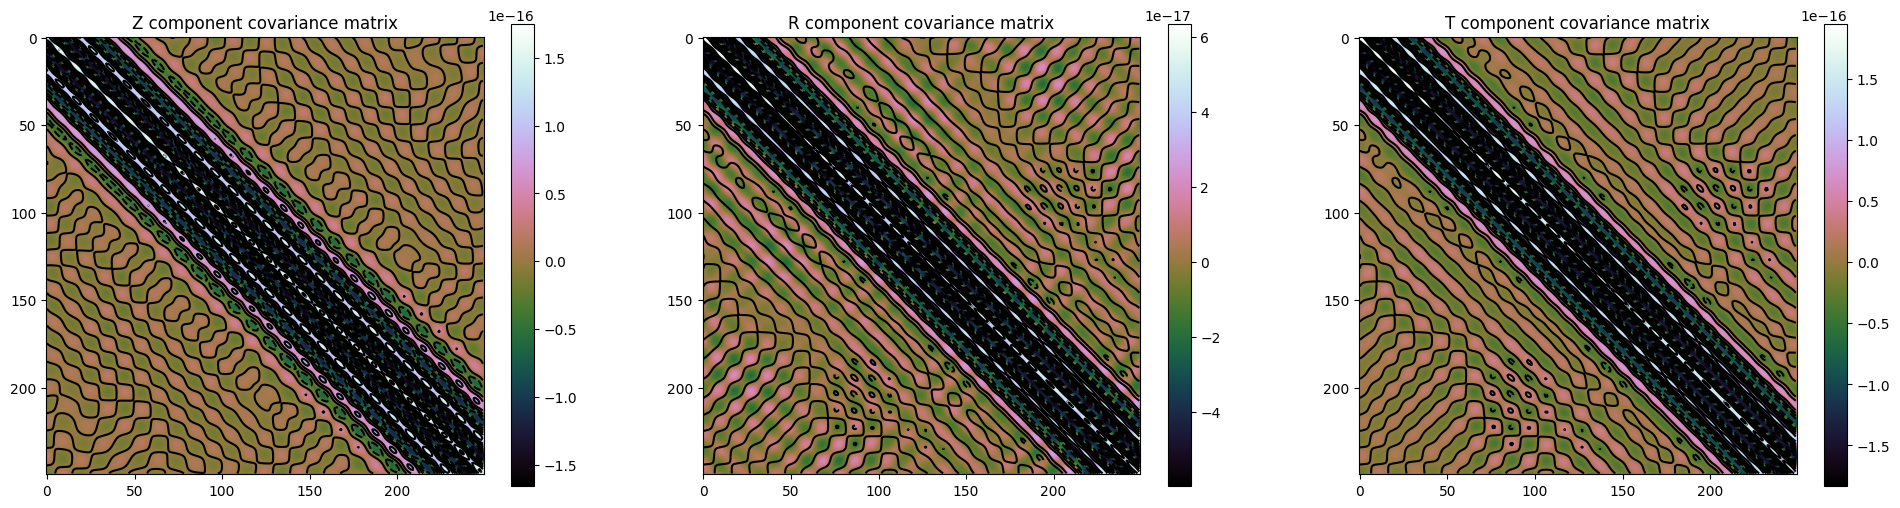

mean max 1.540009073609506e-16
new max 1.540009073609506e-16
new max 1.540009073609506e-16
new max 1.540009073609506e-16
Cd_z_sum:  (-9748.909818966591+0j)
Cd_r_sum:  (-9536.726330830705+0j)
Cd_t_sum:  (-9767.897171306058+0j)
Cd_z_inv_logdet:  4874.4549094832955
Cd_r_inv_logdet:  4768.363165415352
Cd_t_inv_logdet:  4883.948585653029


In [13]:
Cdinv_set = []
Cd_data_set = []
logdet_cdinv_set = []

for i in range(len(sta_lats)):
    Cd_z, Cd_r, Cd_t = covariance_matrices(low_amps_z[i], low_amps_r[i], low_amps_t[i])
    Cd_z += np.eye(Cd_z.shape[0]) * 1e-17  # Add a small value to the diagonal for numerical stability
    Cd_r += np.eye(Cd_r.shape[0]) * 1e-17  # Add a small value to the diagonal for numerical stability
    Cd_t += np.eye(Cd_t.shape[0]) * 1e-17  # Add a small value to the diagonal for numerical stability
    Cd_s = [Cd_z, Cd_r, Cd_t]
    Cd_z_m, Cd_r_m, Cd_t_m = meaning_matrices(Cd_s)
    cdinv_z, cdinv_r, cdinv_t, logdetcdinv_z, logdetcdinv_r, logdetcdinv_t = inverse_and_det(Cd_z_m, Cd_r_m, Cd_t_m)
    Cd_data_set.append([Cd_z, Cd_r, Cd_t])
    Cdinv_set.append([cdinv_z, cdinv_r, cdinv_t])
    logdet_cdinv_set.append([logdetcdinv_z, logdetcdinv_r, logdetcdinv_t])

In [14]:
# setting up the G matrix (the elementary functions)

# GSF = np.transpose([SF_e1, SF_e2, SF_e3])
# GMT = np.transpose([MT_e1, MT_e2, MT_e3, MT_e4, MT_e5, MT_e6])

Glist = []
for i in range(len(stations)):
    GSF = np.transpose([SF_e1[i], SF_e2[i], SF_e3[i]])
    GMT = np.transpose([MT_e1[i], MT_e2[i], MT_e3[i], MT_e4[i], MT_e5[i], MT_e6[i]])
    Glist.append([GSF, GMT]) # list of G matrices for each state

In [15]:
# reasonable noise via son's model

stations = list(set([tr.stats.station for tr in real_station_streams[0]]))

son_model_exact = np.array([4.0,-9.0,4.0])
res_z,res_r,res_t = calc_residuals(son_model_exact, 0, Glist, ydatas) # calculate waveform residuals of Son's model
res = [res_z,res_r,res_t]

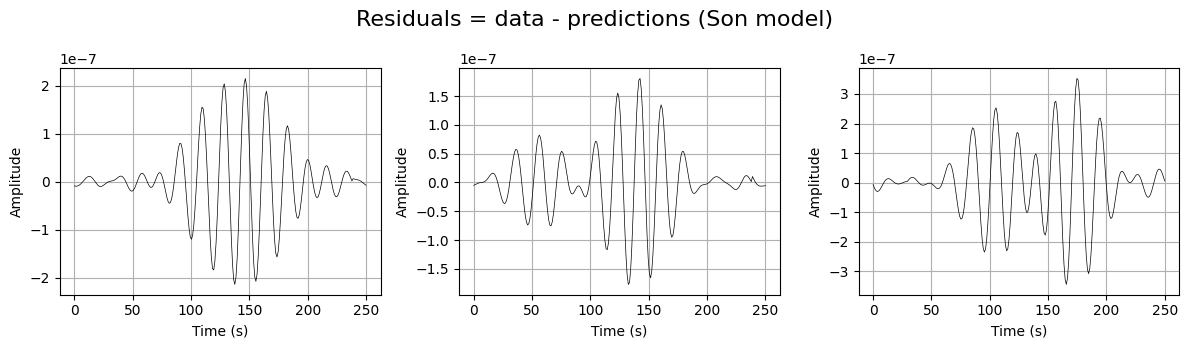

In [16]:
# Now plot the residual waveforms of Son's model

fig_height = 3.5  # Adjust scaling as needed
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True)
noise_stat,noise_realization = 0,6
noise = [low_amps_z,low_amps_r,low_amps_t]
#cdn = [cd_z,cd_r,cd_t]
res = [res_z,res_r,res_t]
time_x = np.linspace(0,250,250)
for i in range(len(stations)):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        #ax.plot(time_x, ydatas[0][:, j], c='k', label=f'{stations[i]} {comp}')
        #ax.plot(time_x, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
        ax.plot(time_x,res[j][0],c='k',lw=0.5)
        ax.set_ylabel(f'Amplitude')
        ax.set_xlabel('Time (s)')
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
plt.suptitle('Residuals = data - predictions (Son model)', fontsize=16)
plt.tight_layout()
plt.show()    

## Point of Divergence

In [17]:
reduced = True       # use Maximum Likelihood estimation of MLcov and reduced Likelihood << keep this one to use Malcolm's methods
redcase = 4          # level of approximation in data covariance matrix [1 or 4 (Default)]. Only if reduced is True.
redsampling = False   # Sample from the reduced Likelihood (True) or full Likelihood with ML data covariances

In [18]:
Cd_set,Cdinv_set,Cd_set_ref,Cdinv_set_ref = calc_Cd_from_res(res,Cd_data_set,Cdinv_set,redcase) # get ML data covarince from Son's model residuals (for plotting)

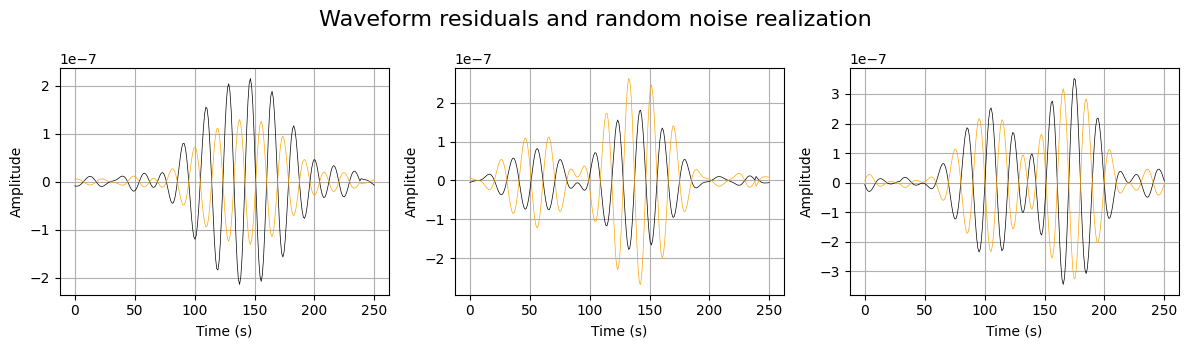

In [19]:
# Now plot the input noise signals with a realization from the estimated Gaussian to see if they fit << note the above fits to a half-phase (- vs +)

fig_height = 3.5  # Adjust scaling as needed
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True)
noise_stat,noise_realization = 0,6
noise = [low_amps_z,low_amps_r,low_amps_t]
#cdn = [cd_z,cd_r,cd_t]
res = [res_z,res_r,res_t]
for i in range(len(stations)):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        #ax.plot(time_x, ydatas[0][:, j], c='k', label=f'{stations[i]} {comp}')
        #ax.plot(time_x, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
        ax.plot(time_x,res[j][0],c='k',lw=0.5)
        ax.plot(time_x,np.random.multivariate_normal(np.zeros(250),Cd_set[i][j]),c='orange',lw=0.5)
        ax.set_ylabel(f'Amplitude')
        ax.set_xlabel('Time (s)')
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
plt.suptitle('Waveform residuals and random noise realization', fontsize=16)
plt.tight_layout()
plt.show()  

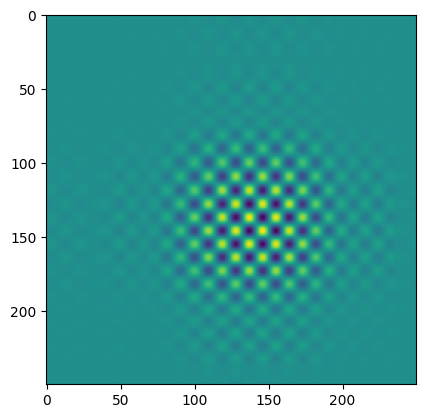

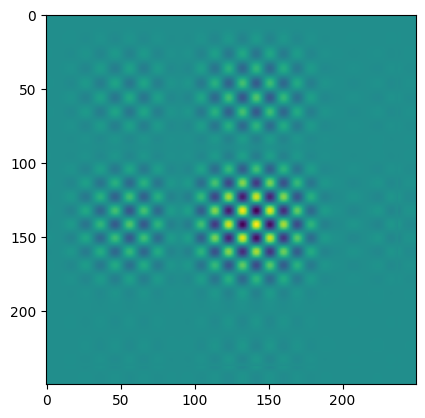

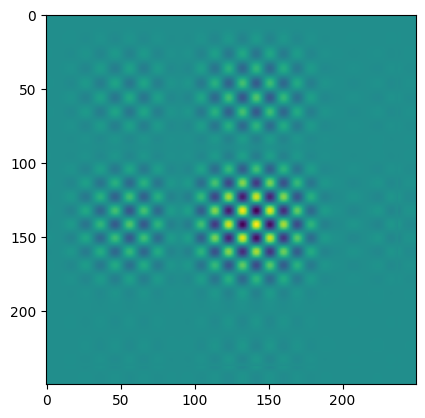

In [20]:
plot_covariances = True
if(plot_covariances):
    # plot data covariance matrices
    plt.imshow(Cd_set[0][0],cmap='viridis')
    plt.show()
    plt.imshow(Cd_set[0][1],cmap='viridis')
    plt.show()
    plt.imshow(Cd_set[0][1],cmap='viridis')
    plt.show()

In [21]:
# defining the dimensional space of the thing
nstates = 2
ndims = [3, 6] # 3 for SF, 6 for MT
sigmas = [50, 50] # weaker prior model covariance << this has made the prior much stronger

# prior PDF parameters (approximate expected parameter values)
mu_SF = [4, -9, 4] # << more or less taken fron Son's -2.747817857774633 1.7271417083824983 6.147906282830952
mu_MT = [25, -29, -30, 20, 1, -50] # << a guess 26.978422827945437 -25.430668819981314 -15.52056466383073 13.11266483895689 -2.9515670217858716 -41.58499996697125
mu = [mu_SF, mu_MT]

# covariance / data covariance matrices
cov =   [np.eye(ndims[i]) * sigmas[i]**2 for i in range(nstates)] # covariance matrices for each state
#cdinv = [np.eye(num_points)/sigmas[i]**2 for i in range(nstates)] # inverse data covariance matrices for each state

############### here and below needs to be edited

#Cdinv_SF = [Cddinv_z, Cddinv_r, Cddinv_t]  # inverse data covariance matrices for SF state << have one of these per station
#Cdinv_MT = [Cddinv_z, Cddinv_r, Cddinv_t]
#cdinv = [[Cdinv_SF, Cdinv_MT], [Cdinv_SF, Cdinv_MT]] # inverse data covariance matrices for each state, 2 stations

# Cdinv_set = [[Cd_z_inv, Cd_r_inv, Cd_t_inv]]  # inverse data covariance matrices for each state << have one of these per station

cdinv = [[Cdinv_set[0], Cdinv_set[0]]]


cov_dets =   [np.linalg.det(cov[i]) for i in range(nstates)]   # determinants of covariance matrices
#log_cdinv_dets = [len(ydata)*3*np.log(sigmas[i]) for i in range(nstates)] # determinants of inverse data covariance matrices

#log_cdinv_dets_SF = [Cddinv_z_logdet, Cddinv_r_logdet, Cddinv_t_logdet]  # log determinants of inverse data covariance matrices for SF state
#log_cdinv_dets_MT = [Cddinv_z_logdet, Cddinv_r_logdet, Cddinv_t_logdet]  # log determinants of inverse data covariance matrices for each state
#log_cdinv_dets = [[log_cdinv_dets_SF, log_cdinv_dets_MT], [log_cdinv_dets_SF, log_cdinv_dets_MT]]  # log determinants of inverse data covariance matrices for each state, 2 stations

# logdet_cdinv_set = [[Cd_z_inv_logdet, Cd_r_inv_logdet, Cd_t_inv_logdet]]

logdet_set = [[None, None, None]]

log_cdinv_dets = [[logdet_set[0], logdet_set[0]]]

In [22]:
# m_lower_bound = np.ones(4) * (-10.)             # lower bound for uniform prior
# m_upper_bound = np.ones(4) * 10                 # upper bound for uniform prior

# def log_prior(model):    # uniform distribution
#     for i in range(len(m_lower_bound)):
#         if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
#     return 0.0 # model lies within bounds -> return log(1)

In [23]:
# setting up the log likelihood function
def log_likelihood(x, state, y, cdinv, log_cdinv_dets, Glist, align=True, verbose=False,returnlikes=False):
    '''
    Gaussian log likelihood function - requires you to input the "G matrix" for each state you want to test
    y is the data going in
    '''
    
    ll_z_sum, ll_n_sum, ll_e_sum = 0, 0, 0
    ll_zs,ll_ns,ll_es = [],[],[]
    
    for i in range(len(stations)):
        G = Glist[i][state]
        Cdinv_z, Cdinv_n, Cdinv_e = cdinv[i][state]
        Cdinv_det_z, Cdinv_det_n, Cdinv_det_e = log_cdinv_dets[i][state]
        data_z, data_r, data_t = y[i][:,0], y[i][:,1], y[i][:,2]
        model_z, model_r, model_t = np.dot(G[:,0], x), np.dot(G[:,1], x), np.dot(G[:,2], x)
        
        if(align):
            d_obs = np.vstack((data_z, data_r, data_t))
            d_pred = np.vstack((model_z, model_r, model_t))
            residuals, tshifts = station_residual(d_obs, d_pred, max_shift=50, shifts_per_station=3, return_tshift=True)
            if(verbose):
                print(' Station ', i, ' offsets detected ', -tshifts)
            aligned = np.zeros_like(d_pred)
            for j in range(3): aligned[j] = np.roll(d_pred[j], -tshifts[j])
            model_z, model_r, model_t = aligned
        
        r_z = data_z - model_z
        r_n = data_r - model_r
        r_e = data_t - model_t
        ll_z = -.5 * r_z @ Cdinv_z @ r_z.T
        ll_n = -.5 * r_n @ Cdinv_n @ r_n.T
        ll_e = -.5 * r_e @ Cdinv_e @ r_e.T
        
        #ll_z += -0.5*len(data_z)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_z)
        #ll_n += -0.5*len(data_r)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_n)
        #ll_e += -0.5*len(data_t)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_e)
        ll_zs.append(ll_z)
        ll_ns.append(ll_n)
        ll_es.append(ll_e)
        
        ll_z_sum += ll_z
        ll_n_sum += ll_n
        ll_e_sum += ll_e

    if(returnlikes): return ll_z_sum + ll_n_sum + ll_e_sum,ll_zs,ll_ns,ll_es
    return ll_z_sum + ll_n_sum + ll_e_sum      


In [24]:
# setting up the reduced log likelihood function
def reduced_log_likelihood(x, state, y, cdinv, log_cdinv_dets, Glist, align=True, verbose=False,returnlikes=False):
    '''
    Gaussian log likelihood function - requires you to input the "G matrix" for each state you want to test
    y is the data going in
    '''
    
    ll_z_sum, ll_n_sum, ll_e_sum = 0, 0, 0
    ll_zs,ll_ns,ll_es = [],[],[]
    
    for i in range(len(stations)):
        G = Glist[i][state]
        data_z, data_r, data_t = y[i][:,0], y[i][:,1], y[i][:,2]
        model_z, model_r, model_t = np.dot(G[:,0], x), np.dot(G[:,1], x), np.dot(G[:,2], x)
        
        if(align):
            d_obs = np.vstack((data_z, data_r, data_t))
            d_pred = np.vstack((model_z, model_r, model_t))
            residuals, tshifts = station_residual(d_obs, d_pred, max_shift=50, shifts_per_station=3, return_tshift=True)
            if(verbose):
                print(' Station ', i, ' offsets detected ', -tshifts)
            aligned = np.zeros_like(d_pred)
            for j in range(3): aligned[j] = np.roll(d_pred[j], -tshifts[j])
            model_z, model_r, model_t = aligned
        
        r_z = data_z - model_z
        r_n = data_r - model_r
        r_e = data_t - model_t

        if(redcase == 1):
            Cdinv_z, Cdinv_n, Cdinv_e = cdinv[i][state]
            ll_z = -0.5 * len(r_z)*np.log(r_z @ Cdinv_z @ r_z.T)
            ll_n = -0.5 * len(r_n)*np.log(r_n @ Cdinv_n @ r_n.T)
            ll_e = -0.5 * len(r_e)*np.log(r_e @ Cdinv_e @ r_e.T)
        else:
            ll_z = -0.5*np.log(r_z @ r_z.T)
            ll_n = -0.5*np.log(r_n @ r_n.T)
            ll_e = -0.5*np.log(r_e @ r_e.T)

        ll_zs.append(ll_z)
        ll_ns.append(ll_n)
        ll_es.append(ll_e)
        
        ll_z_sum += ll_z
        ll_n_sum += ll_n
        ll_e_sum += ll_e

    if(returnlikes): return ll_z_sum + ll_n_sum + ll_e_sum,ll_zs,ll_ns,ll_es
    return ll_z_sum + ll_n_sum + ll_e_sum   


In [25]:
# print out table of fits for selected models
mu_SF_model = np.array(mu[0])
mu_MT_model = np.array(mu[1])
son_model_exact = np.array([4.0,-9.0,4.0])
print(f'Mu SF model:   {mu_SF_model[0]:.3f}, {mu_SF_model[1]:.3f}, {mu_SF_model[2]:.3f} \n  LL: {log_likelihood(mu_SF_model, 0, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  rLL: {reduced_log_likelihood(mu_SF_model, 0, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  log-prior: {log_prior(mu_SF_model, 0, mu, cov, cov_dets):.3f}  log-p: {log_likelihood(mu_SF_model, 0, ydatas, cdinv, log_cdinv_dets, Glist)+log_prior(mu_SF_model, 0, mu, cov, cov_dets):.3f}')
print(f'--------------------------------------------------------------')
print(f'Mu MT model:   {mu_MT_model[0]:.3f}, {mu_MT_model[1]:.3f}, {mu_MT_model[2]:.3f}  {mu_MT_model[3]:.3f}, {mu_MT_model[4]:.3f}, {mu_MT_model[5]:.3f} \n  LL: {log_likelihood(mu_MT_model, 1, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  rLL: {reduced_log_likelihood(mu_MT_model, 1, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  log-prior: {log_prior(mu_MT_model, 1, mu, cov, cov_dets):.3f}   log-p: {log_likelihood(mu_MT_model, 1, ydatas, cdinv, log_cdinv_dets, Glist)+log_prior(mu_MT_model, 1, mu, cov, cov_dets):.3f}')
print(f'--------------------------------------------------------------')
print(f'Son model:  {son_model_exact[0]:.3f}, {son_model_exact[1]:.3f}, {son_model_exact[2]:.3f} \n  LL: {log_likelihood(son_model_exact, 0, ydatas, cdinv, log_cdinv_dets, Glist):.3f}  rLL: {reduced_log_likelihood(son_model_exact, 0, ydatas, cdinv, log_cdinv_dets, Glist):.3f} log-prior: {log_prior(son_model_exact, 0, mu, cov, cov_dets):.3f}   log-p: {log_likelihood(son_model_exact, 0, ydatas, cdinv, log_cdinv_dets, Glist)+log_prior(son_model_exact, 0, mu, cov, cov_dets):.3f}')
#print(f'Map model:   {map_model[0]:.3f}, {map_model[1]:.3f}, {map_model[2]:.3f}   LL: {log_likelihood(map_model):.3f}   log-prior: {log_prior(map_model, 0, mu, cov, cov_dets):.3f}   log-p: {lp_max:.3f}   index: {max_arg}')
#print(f'Bad model:   {bad_model[0]:.3f}, {bad_model[1]:.3f}, {bad_model[2]:.3f}  LL: {log_likelihood(bad_model):.3f}   log-prior: {log_prior(bad_model, 0, mu, cov, cov_dets):.3f}  log-p: {lp_min:.3f}   index: {min_arg}')

Mu SF model:   4.000, -9.000, 4.000 
  LL: -0.000  rLL: 43.923  log-prior: -14.493  log-p: -14.493
--------------------------------------------------------------
Mu MT model:   25.000, -29.000, -30.000  20.000, 1.000, -50.000 
  LL: -0.000  rLL: 43.859  log-prior: -28.986   log-p: -28.986
--------------------------------------------------------------
Son model:  4.000, -9.000, 4.000 
  LL: -0.000  rLL: 43.923 log-prior: -14.493   log-p: -14.493


In [26]:
# setting up the log posterior function
def log_posterior(x, state, y, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets):
    '''
    log posterior = log likelihood + log prior
    '''
    if(redsampling):
        lp = reduced_log_likelihood(x, state, y, cdinv, log_cdinv_dets, Glist)
    else:
        lp = log_likelihood(x, state, y, cdinv, log_cdinv_dets, Glist) 
    lp += log_prior(x,state,mu,cov, cov_dets)
    return lp

log_posterior_args = [ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets]  

In [27]:
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = np.array(mu[i]) # arbitrary initial guesses for optimisation
    if(reduced): 
        print(f' Optimising reduced log likelihood for state {i}...') # x, state, y, cdinv, log_cdinv_dets, Glist,
        obj_fun = lambda *args: -reduced_log_likelihood(*args)
        soln = minimize(obj_fun, initial, args=(i, ydatas, cdinv, log_cdinv_dets, Glist), method='nelder-mead')
        ml.append(soln.x)
        print(soln.x)
        #print("x_ml = {0:.3f}".format(soln.x[0]))
        print(f'NLL of starting model {i} prior to minimisation: {obj_fun(initial, i, ydatas, cdinv, log_cdinv_dets, Glist):.3f}')
        print(f'NLL of ML model {i} after minimisation: {obj_fun(soln.x, i, ydatas, cdinv, log_cdinv_dets, Glist):.3f}')
    else:
        print(f' Optimising full log likelihood for state {i}...') # x, state, y, cdinv, log_cdinv_dets, Glist,
        obj_fun = lambda *args: -log_posterior(*args)
        soln = minimize(obj_fun, initial, args=(i, ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets), method='nelder-mead')
        ml.append(soln.x)
        print(soln.x)
        #print("x_ml = {0:.3f}".format(soln.x[0]))
        print(f'NLL of starting model {i} prior to minimisation: {obj_fun(initial, i, ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets):.3f}')
        print(f'NLL of ML model {i} after minimisation: {obj_fun(soln.x, i, ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets):.3f}')


Maximum likelihood estimates:
 Optimising reduced log likelihood for state 0...
[ 3.67015686 -7.14943218  2.28048765]
NLL of starting model 0 prior to minimisation: -43.923
NLL of ML model 0 after minimisation: -44.789
 Optimising reduced log likelihood for state 1...
[-1.74860468e+03 -7.09674540e+02 -8.51795980e+02  2.03837571e+01
  1.43060124e-01  2.05592128e+01]
NLL of starting model 1 prior to minimisation: -43.859
NLL of ML model 1 after minimisation: -44.440


In [28]:
ml

[array([ 3.67015686, -7.14943218,  2.28048765]),
 array([-1.74860468e+03, -7.09674540e+02, -8.51795980e+02,  2.03837571e+01,
         1.43060124e-01,  2.05592128e+01])]

In [29]:
# calculating corresponding ML data covariances for best-fit model, to use in sampling

if(reduced): # Now find the data covariance and inverse data covariance from the best fit residuals (Only used subsequently if redsampling is False)
    cdinvs = []
    cd_sets = []
    for i in range(nstates):
        print(f' Calculating ML data covariance from residuals of state {i} ML model...')
        solopt = ml[i]
        if i == 1:
            res_z, res_r, res_t = calc_residuals(solopt, i, Glist, ydatas) # calculate waveform residuals of optimised model
        else:
            res_z, res_r, res_t = calc_residuals(solopt, i, Glist, ydatas) # calculate waveform residuals of optimised model
        res = [res_z, res_r, res_t]
        Cd_set, Cdinv_set, Cd_set_ref, Cdinv_set_ref = calc_Cd_from_res(res, Cd_set_ref, Cdinv_set_ref, redcase)
        cdinvs.append(Cdinv_set[0])
        cd_sets.append(Cd_set[0])
    cdinv = [[cdinvs[0], cdinvs[1]]]
    cdset = [[cd_sets[0], cd_sets[1]]]
    log_posterior_args = [ydatas, cdinv, log_cdinv_dets, Glist, mu, cov, cov_dets]

 Calculating ML data covariance from residuals of state 0 ML model...
 Calculating ML data covariance from residuals of state 1 ML model...


In [30]:
# setup of MCMC sampler
nsamples =[30000, 30000] # number of samples per chain for sampling of each state
nwalkers = [64,64] # number of mcmc chains to run simultaneously in each state
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers[i], ndims[i])) # add random perturbation to maximum Likelihood models

In [31]:
# perform initiation of sampler
tcs3 = TransC_Sampler(nstates,ndims) # create instances of states

In [32]:
# first step: run Ensemble sampler in each state
start_time = time.time()
ensemble_per_state, log_posterior_ens = tcs3.run_mcmc_per_state( 
        nwalkers,                                  # int or list containing number of walkers for each state
        nsamples,                                  # number of chain steps per walker
        pos,                                       # starting positions for walkers in each state
        log_posterior,                             # log Likelihood x log_prior
        log_posterior_args=log_posterior_args,     # log posterior additional arguments (optional)
        discard=0,                                 # burnin number of chain steps to discard in eeach state
        autothin=True,                             # thinning value, save every `thin` models
        progress=True)                             # show progress bar for each state
elapsed_time = time.time() - start_time
print(' Elapsed time                                     :', np.round(elapsed_time,2),'s \n')
print(' Number of samples in each state                  :',*[len(tcs3.ensemble_per_state[i]) for i in range(nstates)])


Running within-state sampler separately on each state

Number of walkers               :  [64, 64]

Number of states being sampled:  2
Dimensions of each state:  [3, 6]


100%|██████████| 30000/30000 [57:45<00:00,  8.66it/s]  


 Elapsed time                                     : 10263.68 s 

 Number of samples in each state                  : 95996 58176


In [33]:
log_prior_ens = []
for i in range(nstates):
    ens = ensemble_per_state[i]
    log_prior_ens.append([log_prior(ens[k], i, mu, cov, cov_dets) for k in range(len(ens))])
log_pseudo_prior_ens = log_prior_ens # NB we set the log-pseudo-prior values to the log-prior values

In [34]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers = 64   # number of independent random walkers across ensembles
nsteps = 400000 # number of chain steps for each walker
start_time = time.time()
result = tcs3.run_ensemble_resampler(nwalkers,
                                   nsteps,
                                   progress=True,
                                   parallel=parallel,
                                   log_posterior_ens=log_posterior_ens,
                                   log_pseudo_prior_ens=log_pseudo_prior_ens) # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time


Running ensemble trans-D resampler

Number of walkers               :  64
Number of states being sampled  :  2
Dimensions of each state        :  [3, 6]


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [23:34<00:00, 22.09s/it]


In [35]:
chain, states_chain = print_diagnostics(tcs3, elapsed_time)


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 89.57
 Auto correlation time for between state sampling    : -0.622
 Total number of state changes for all walkers       : 881960
 Estimated relative evidences                        : 0.44791 0.55209
 Elapsed time                                        : 1414.06 s 



 State;  0  in  3  dimensions
 State;  1  in  6  dimensions


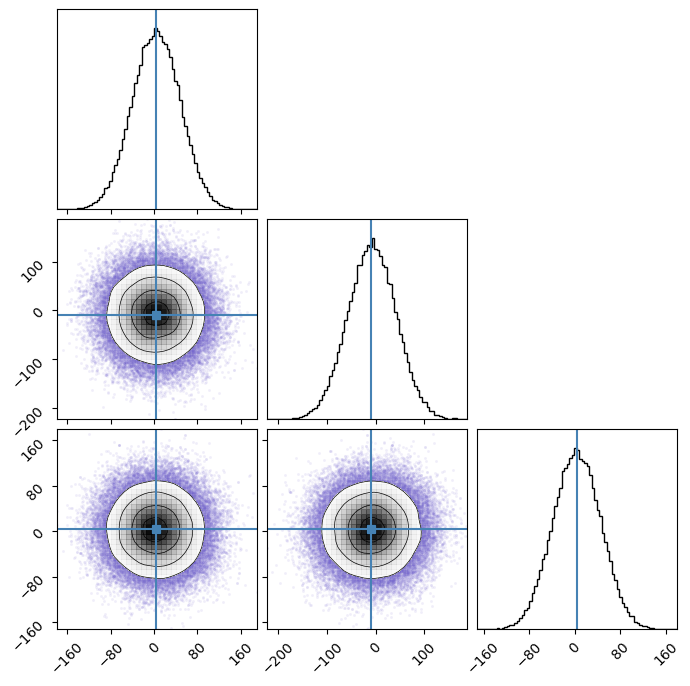

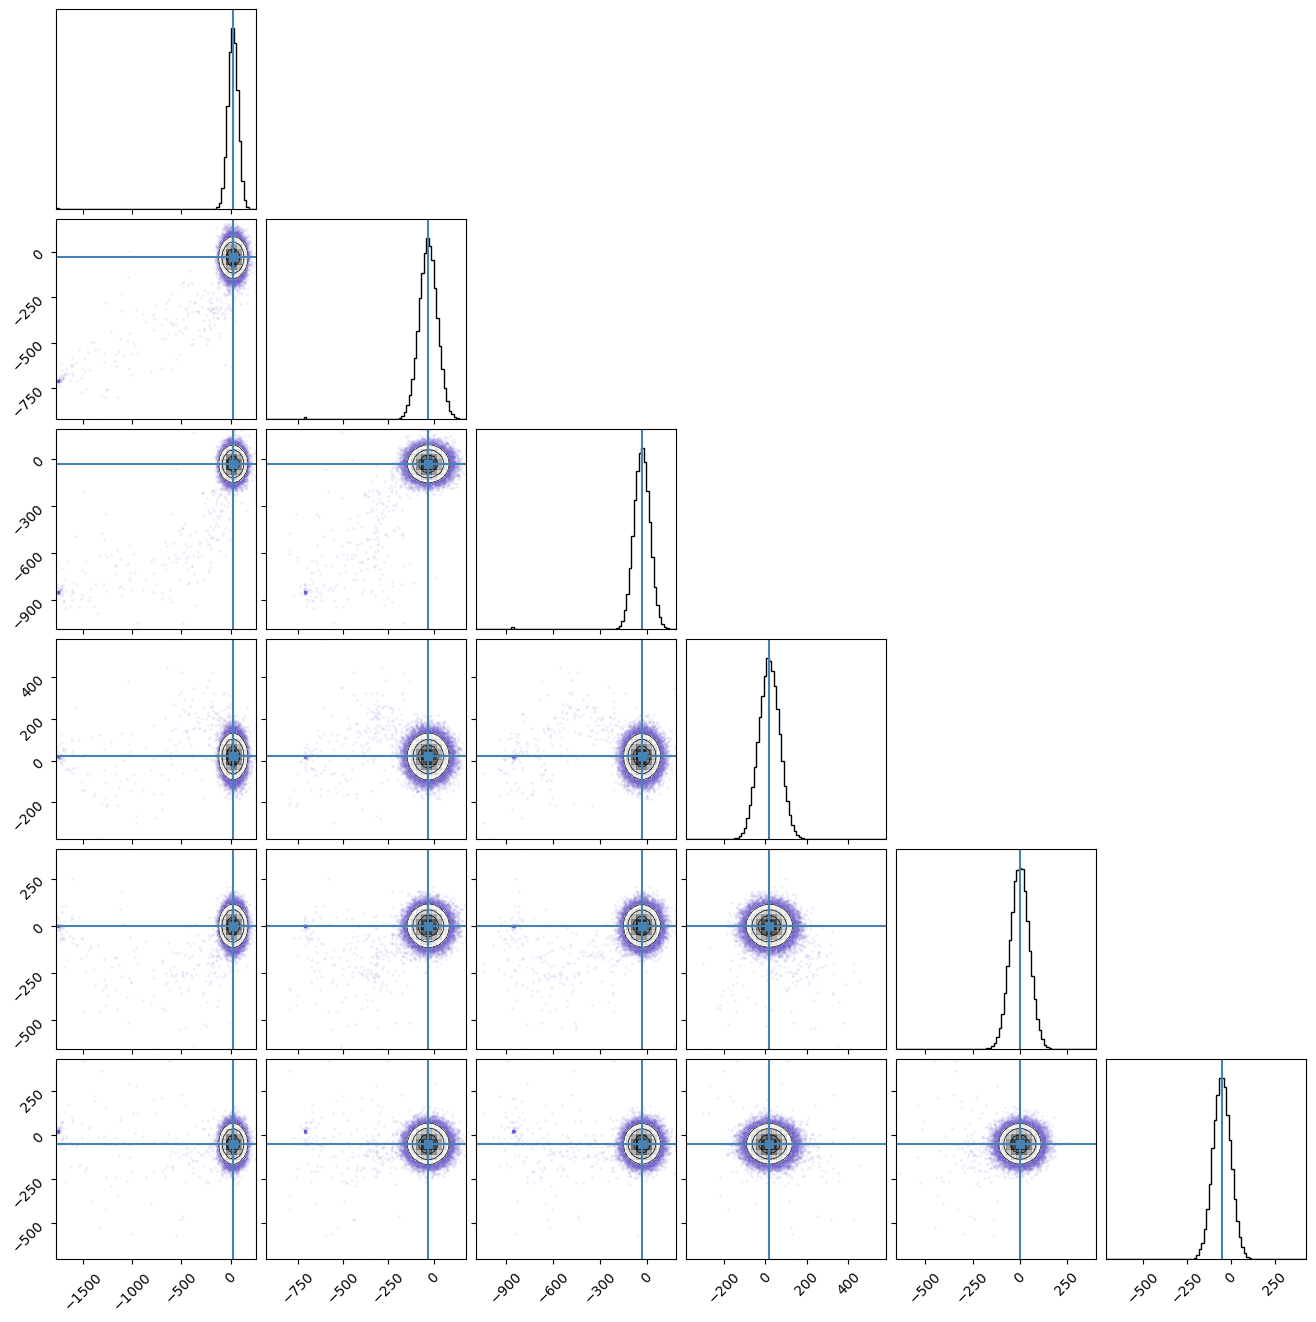

In [36]:
corner_plot = corner_plots(ensemble_per_state, mu, nstates, ndims)

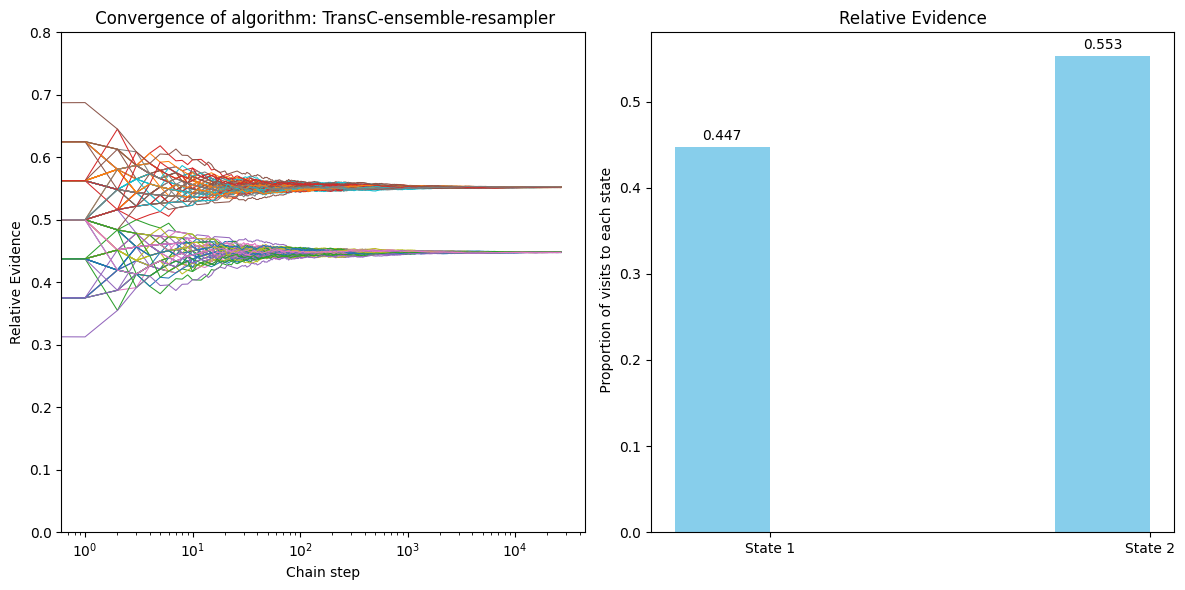

In [37]:
ratio_plot = plot_ratios(tcs3, chain, states_chain, nstates, nsamples=400000)

In [38]:
stations

['UNGL']

In [39]:
# SFs = [SF_e1, SF_e2, SF_e3]
# MTs = [MT_e1, MT_e2, MT_e3, MT_e4, MT_e5, MT_e6]
# other_infos = [mu, cov, cov_dets, ydatas, cdinv, log_cdinv_dets, Glist, stations]

# SF_force_opt_MAP, MT_force_opt_MAP, SF_force_az_MAP, SF_opt_signals_MAP, MT_opt_signals_MAP = MAP_stuff(tcs3, scaling_SF, scaling_MT, SFs, MTs, other_infos)

max_arg_SF = np.argmax(tcs3.log_posterior_ens[0])
print(max_arg_SF)
max_arg_MT = np.argmax(tcs3.log_posterior_ens[1])
print(max_arg_MT)
min_arg_SF = np.argmin(tcs3.log_posterior_ens[0])
print(min_arg_SF)
min_arg_MT = np.argmin(tcs3.log_posterior_ens[1])
print(min_arg_MT)

print('--------------------------------------------')

print(f'log posterior SF max: {tcs3.log_posterior_ens[0][max_arg_SF]}')
print(f'log prior + log likelihood SF max: {log_prior(tcs3.ensemble_per_state[0][max_arg_SF], 0, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[0][max_arg_SF], 0, ydatas, cdinv, log_cdinv_dets, Glist)}')
print(f'log posterior MT max: {tcs3.log_posterior_ens[1][max_arg_MT]}')
print(f'log prior + log likelihood MT max: {log_prior(tcs3.ensemble_per_state[1][max_arg_MT], 1, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[1][max_arg_MT], 1, ydatas, cdinv, log_cdinv_dets, Glist)}')
print(f'log posterior SF min: {tcs3.log_posterior_ens[0][min_arg_SF]}')
print(f'log prior + log likelihood SF min: {log_prior(tcs3.ensemble_per_state[0][min_arg_SF], 0, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[0][min_arg_SF], 0, ydatas, cdinv, log_cdinv_dets, Glist)}')
print(f'log posterior MT min: {tcs3.log_posterior_ens[1][min_arg_MT]}')
print(f'log prior + log likelihood MT min: {log_prior(tcs3.ensemble_per_state[1][min_arg_MT], 1, mu, cov, cov_dets)} + {log_likelihood(tcs3.ensemble_per_state[1][min_arg_MT], 1, ydatas, cdinv, log_cdinv_dets, Glist)}')

print('--------------------------------------------')

print('Most likely: ')
print(tcs3.ensemble_per_state[0][max_arg_SF]) # SF MAP
print(tcs3.ensemble_per_state[1][max_arg_MT]) # MT MAP
print('Least likely: ')
print(tcs3.ensemble_per_state[0][min_arg_SF]) # SF least likely
print(tcs3.ensemble_per_state[1][min_arg_MT]) # MT least likely

# finding the selected optimised values (map)

SF_opt_1_map, SF_opt_2_map, SF_opt_3_map = tcs3.ensemble_per_state[0][max_arg_SF]
SF_opt_params = [SF_opt_1_map, SF_opt_2_map, SF_opt_3_map]
MT_opt_1_map, MT_opt_2_map, MT_opt_3_map, MT_opt_4_map, MT_opt_5_map, MT_opt_6_map = tcs3.ensemble_per_state[1][max_arg_MT]
MT_opt_params = [MT_opt_1_map, MT_opt_2_map, MT_opt_3_map, MT_opt_4_map, MT_opt_5_map, MT_opt_6_map]

SF_force_opt_MAP = ([SF_opt_1_map, SF_opt_2_map, SF_opt_3_map])*scaling_SF
MT_force_opt_MAP = ([MT_opt_1_map, MT_opt_2_map, MT_opt_3_map, MT_opt_4_map, MT_opt_5_map, MT_opt_6_map])*scaling_MT

print('--------------------------------------------')

print('SF force optimised (N): ', SF_force_opt_MAP)
print('MT force optimised (N): ', MT_force_opt_MAP)

SF_force_az_MAP = 180 - np.arctan(SF_force_opt_MAP[2] / SF_force_opt_MAP[1])
print(SF_force_az_MAP)

sliprate = stf_tsai2007(source_duration=15, deltat=coche.dt)
CSFamp = np.max(np.cumsum(np.cumsum(sliprate)) * coche.dt**2 * np.sqrt(np.sum(SF_force_opt_MAP**2)))
txt = f"CSF amp: {CSFamp/1e11:.1f}" + "$10^{11}$ kg-m"
print(txt)  

SF_opt_signals_MAP = []
MT_opt_signals_MAP = []

for i in range(len(stations)):
    SF_optimised_z = SF_opt_1_map*SF_e1[i][0] + SF_opt_2_map*SF_e2[i][0] + SF_opt_3_map*SF_e3[i][0]
    SF_optimised_r = SF_opt_1_map*SF_e1[i][1] + SF_opt_2_map*SF_e2[i][1] + SF_opt_3_map*SF_e3[i][1]
    SF_optimised_t = SF_opt_1_map*SF_e1[i][2] + SF_opt_2_map*SF_e2[i][2] + SF_opt_3_map*SF_e3[i][2]

    SF_opt_signals_MAP.append([SF_optimised_z, SF_optimised_r, SF_optimised_t])

    MT_optimised_z = MT_opt_1_map*MT_e1[i][0] + MT_opt_2_map*MT_e2[i][0] + MT_opt_3_map*MT_e3[i][0] + MT_opt_4_map*MT_e4[i][0] + MT_opt_5_map*MT_e5[i][0] + MT_opt_6_map*MT_e6[i][0]
    MT_optimised_r = MT_opt_1_map*MT_e1[i][1] + MT_opt_2_map*MT_e2[i][1] + MT_opt_3_map*MT_e3[i][1] + MT_opt_4_map*MT_e4[i][1] + MT_opt_5_map*MT_e5[i][1] + MT_opt_6_map*MT_e6[i][1]
    MT_optimised_t = MT_opt_1_map*MT_e1[i][2] + MT_opt_2_map*MT_e2[i][2] + MT_opt_3_map*MT_e3[i][2] + MT_opt_4_map*MT_e4[i][2] + MT_opt_5_map*MT_e5[i][2] + MT_opt_6_map*MT_e6[i][2]

    MT_opt_signals_MAP.append([MT_optimised_z, MT_optimised_r, MT_optimised_t])

92
47970
58210
70
--------------------------------------------
log posterior SF max: -14.493286569888971
log prior + log likelihood SF max: -14.49303227192345 + -0.0002542979655207512
log posterior MT max: -29.00730800383274
log prior + log likelihood MT max: -29.00714520636741 + -0.00016279746532805474
log posterior SF min: -29.413167774535378
log prior + log likelihood SF min: -26.379289782361276 + -3.0338779921741015
log posterior MT min: -895.3653622386306
log prior + log likelihood MT min: -895.3651923650467 + -0.00016987358388177793
--------------------------------------------
Most likely: 
[ 4.1196545  -8.53469908  3.28763915]
[ 26.00279577 -23.51117424 -34.9989798   15.8468925    4.82569157
 -54.34431218]
Least likely: 
[-119.54449944  117.75907221  171.63329056]
[-1758.86383896  -713.1762542   -853.0829742     26.80174627
     4.09496439    14.09639565]
--------------------------------------------
SF force optimised (N):  [ 4.11965450e+09 -8.53469908e+08  3.28763915e+09]
MT fo

In [40]:
SF_1_son, SF_2_son, SF_3_son = [4, -9, 4]
SF_params_son = [SF_1_son, SF_2_son, SF_3_son]
SF_force_opt_son = ([SF_1_son, SF_2_son, SF_3_son])*scaling_SF
SF_optimised_signals_son = []
for i in range(len(stations)):
    SF_optimised_z = SF_1_son*SF_e1[i][0] + SF_2_son*SF_e2[i][0] + SF_3_son*SF_e3[i][0]
    SF_optimised_r = SF_1_son*SF_e1[i][1] + SF_2_son*SF_e2[i][1] + SF_3_son*SF_e3[i][1]
    SF_optimised_t = SF_1_son*SF_e1[i][2] + SF_2_son*SF_e2[i][2] + SF_3_son*SF_e3[i][2]

    SF_optimised_signals_son.append([SF_optimised_z, SF_optimised_r, SF_optimised_t])

In [41]:
test_checker_x = np.linspace(-150, 100, 250)

# residuals_rms_son = residuals_rms(stations, ydatas, SF_optimised_signals_son, test_checker_x)

In [42]:
# residuals_rms_SF = residuals_rms(stations, ydatas, SF_opt_signals_MAP, test_checker_x)

In [43]:
# residuals_rms_MT = residuals_rms(stations, ydatas, MT_opt_signals_MAP, test_checker_x)

In [44]:
print('Residual Statistics Grid-search SF model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_son = []
residualss_son = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_son, model_r_son, model_t_son = SF_optimised_signals_son[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_son, model_r_son, model_t_son))
    residuals_son, tshifts_son = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' Son et al. 2025 offsets detected ', tshifts_son)
    aligned_son = np.zeros_like(d_model)
    for j in range(3): aligned_son[j] = np.roll(d_model[j], -tshifts_son[j])
    model_z_son, model_r_son, model_t_son = aligned_son
    
    model_son.append([model_z_son, model_r_son, model_t_son])
    
    res_son_z = data_z - model_z_son
    res_son_r = data_r - model_r_son
    res_son_t = data_t - model_t_son
    
    residualss_son.append([res_son_z, res_son_r, res_son_t])

    rms_son_z = np.sqrt(np.mean(res_son_z**2))
    rms_son_r = np.sqrt(np.mean(res_son_r**2))
    rms_son_t = np.sqrt(np.mean(res_son_t**2))
    rmss_z.append(rms_son_z)
    rmss_r.append(rms_son_r)
    rmss_t.append(rms_son_t)

    print(f'  Station {stations[i]} Son et al. 2025 RMS Z: {rms_son_z:.3e}, R: {rms_son_r:.3e}, T: {rms_son_t:.3e}')

print('=' * 50)
print(f'Overall Son et al. 2025 RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print('--------------------------------------------')

print('Residual Statistics SF MAP model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_sf = []
residualss_sf = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_sf, model_r_sf, model_t_sf = SF_opt_signals_MAP[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_sf, model_r_sf, model_t_sf))
    residuals_sf, tshifts_sf = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' SF MAP offsets detected ', tshifts_sf)
    aligned_sf = np.zeros_like(d_model)
    for j in range(3): aligned_sf[j] = np.roll(d_model[j], -tshifts_sf[j])
    model_z_sf, model_r_sf, model_t_sf = aligned_sf

    model_sf.append([model_z_sf, model_r_sf, model_t_sf])

    res_sf_z = data_z - model_z_sf
    res_sf_r = data_r - model_r_sf
    res_sf_t = data_t - model_t_sf

    residualss_sf.append([res_sf_z, res_sf_r, res_sf_t])

    rms_sf_z = np.sqrt(np.mean(res_sf_z**2))
    rms_sf_r = np.sqrt(np.mean(res_sf_r**2))
    rms_sf_t = np.sqrt(np.mean(res_sf_t**2))
    rmss_z.append(rms_sf_z)
    rmss_r.append(rms_sf_r)
    rmss_t.append(rms_sf_t)

    print(f'  Station {stations[i]} SF MAP RMS Z: {rms_sf_z:.3e}, R: {rms_sf_r:.3e}, T: {rms_sf_t:.3e}')

print('=' * 50)
print(f'Overall SF MAP RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print('--------------------------------------------')

print('Residual Statistics MT MAP model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_mt = []
residualss_mt = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_mt, model_r_mt, model_t_mt = MT_opt_signals_MAP[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_mt, model_r_mt, model_t_mt))
    residuals_mt, tshifts_mt = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' MT MAP offsets detected ', tshifts_mt)
    aligned_MT = np.zeros_like(d_model)
    for j in range(3): aligned_MT[j] = np.roll(d_model[j], -tshifts_mt[j])
    model_z_mt, model_r_mt, model_t_mt = aligned_MT

    model_mt.append([model_z_mt, model_r_mt, model_t_mt])

    res_mt_z = data_z - model_z_mt
    res_mt_r = data_r - model_r_mt
    res_mt_t = data_t - model_t_mt

    residualss_mt.append([res_mt_z, res_mt_r, res_mt_t])

    rms_mt_z = np.sqrt(np.mean(res_mt_z**2))
    rms_mt_r = np.sqrt(np.mean(res_mt_r**2))
    rms_mt_t = np.sqrt(np.mean(res_mt_t**2))
    rmss_z.append(rms_mt_z)
    rmss_r.append(rms_mt_r)
    rmss_t.append(rms_mt_t)

    print(f'  Station {stations[i]} MT MAP RMS Z: {rms_mt_z:.3e}, R: {rms_mt_r:.3e}, T: {rms_mt_t:.3e}')

print('=' * 50)
print(f'Overall MT MAP RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')

Residual Statistics Grid-search SF model: 
 Station  0  Son et al. 2025 offsets detected  [np.int64(-12), np.int64(-12), np.int64(30)]
  Station UNGL Son et al. 2025 RMS Z: 1.328e-08, R: 2.762e-08, T: 5.796e-08
Overall Son et al. 2025 RMS Z: 1.328e-08, R: 2.762e-08, T: 5.796e-08
--------------------------------------------
Residual Statistics SF MAP model: 
 Station  0  SF MAP offsets detected  [np.int64(-12), np.int64(-12), np.int64(30)]
  Station UNGL SF MAP RMS Z: 1.239e-08, R: 2.757e-08, T: 4.455e-08
Overall SF MAP RMS Z: 1.239e-08, R: 2.757e-08, T: 4.455e-08
--------------------------------------------
Residual Statistics MT MAP model: 
 Station  0  MT MAP offsets detected  [np.int64(-22), np.int64(-3), np.int64(14)]
  Station UNGL MT MAP RMS Z: 1.689e-08, R: 2.592e-08, T: 5.264e-08
Overall MT MAP RMS Z: 1.689e-08, R: 2.592e-08, T: 5.264e-08


In [2]:
(1.689+2.592+5.264)/3

3.181666666666667

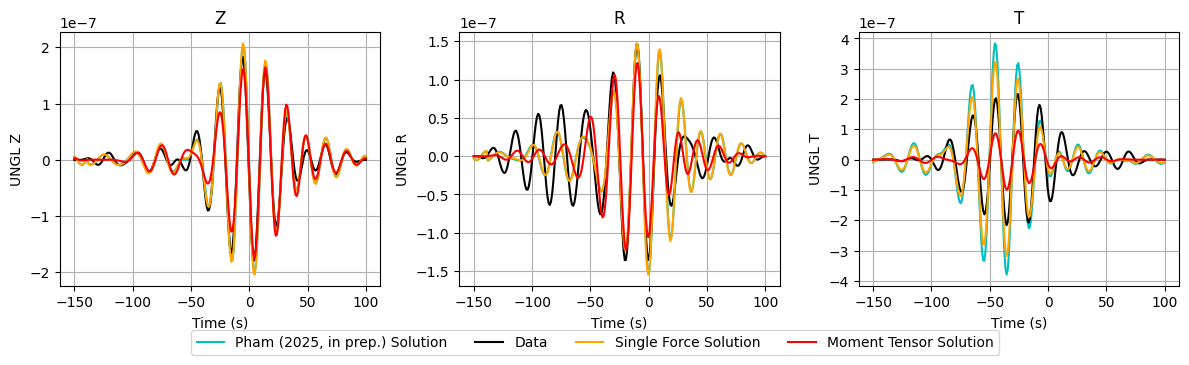

In [46]:
test_checker_x = np.linspace(-150, 100, 250)

n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
        # ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
        # ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
        # ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][0][0] if comp == 'Z' else cdset[0][0][1] if comp == 'R' else cdset[0][0][2]), c='lightgrey', label='ML Data Covariance')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

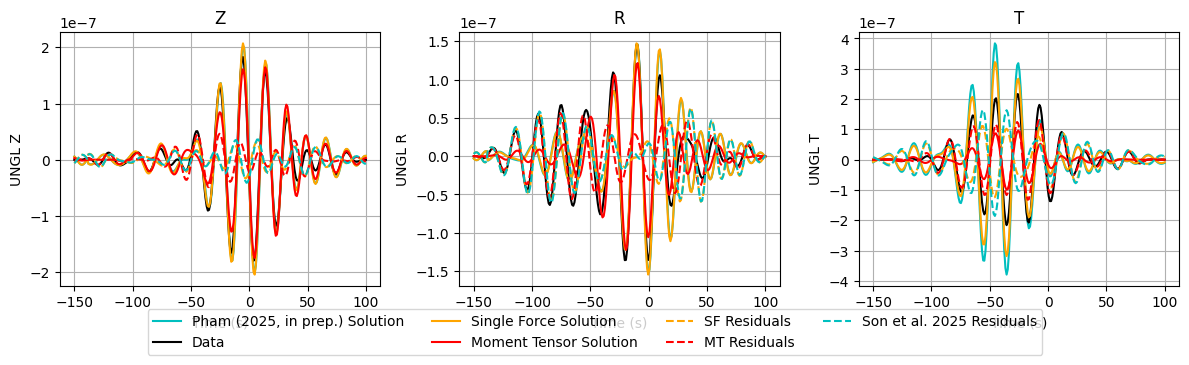

In [47]:
test_checker_x = np.linspace(-150, 100, 250)

n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
        ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][0][0] if comp == 'Z' else cdset[0][0][1] if comp == 'R' else cdset[0][0][2]), c='lightgrey', label='ML Data Covariance')
        # ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

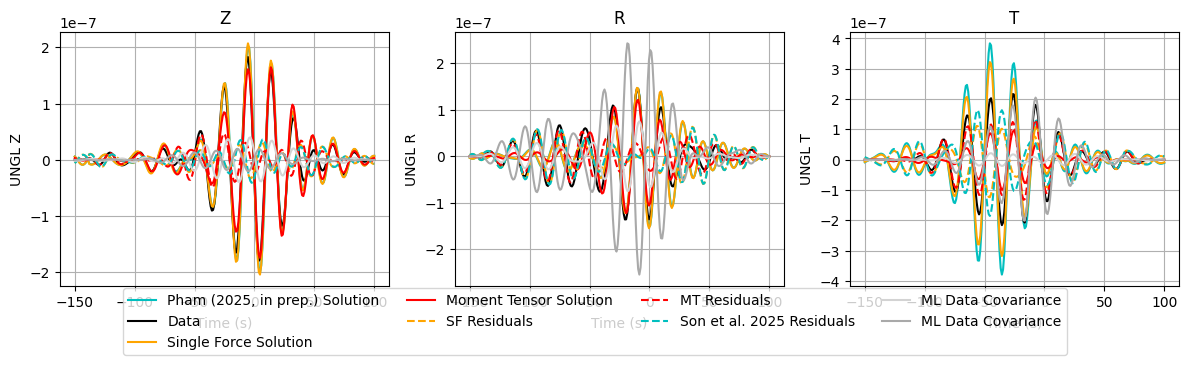

In [48]:
test_checker_x = np.linspace(-150, 100, 250)

n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
        ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][0][0] if comp == 'Z' else cdset[0][0][1] if comp == 'R' else cdset[0][0][2]), c='lightgrey', label='ML Data Covariance')
        ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

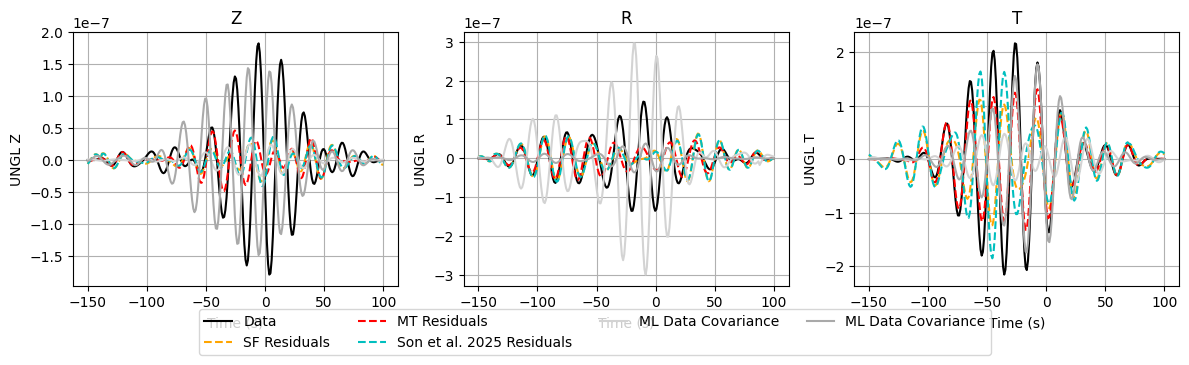

In [49]:
test_checker_x = np.linspace(-150, 100, 250)

n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        # ax.plot(test_checker_x, model_son[i][j], c='c', label='Pham (2025, in prep.) Solution')
        ax.plot(test_checker_x, ydatas[i][:, j], c='k', label='Data')
        # ax.plot(test_checker_x, model_sf[i][j], c='orange', label='Single Force Solution')
        # # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        # ax.plot(test_checker_x, model_mt[i][j], c='r', label='Moment Tensor Solution')
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', ls='--', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='r', ls='--', label='MT Residuals')
        ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][0][0] if comp == 'Z' else cdset[0][0][1] if comp == 'R' else cdset[0][0][2]), c='lightgrey', label='ML Data Covariance')
        ax.plot(test_checker_x, np.random.multivariate_normal(np.zeros(250), cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Trans-Conceptual Source Inversion (Thwaites 2018-11-08)', fontsize=16)
plt.tight_layout()

plt.show()

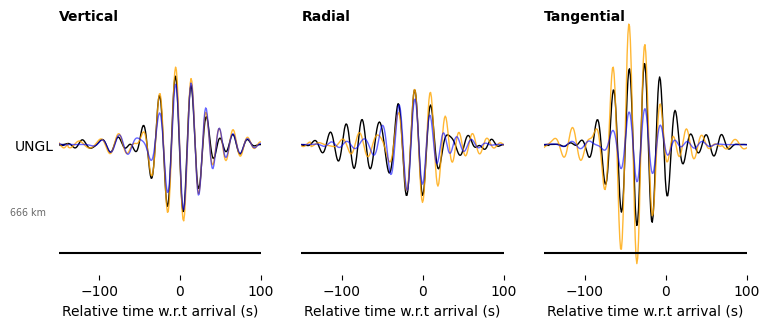

In [50]:
fig = plt.figure(figsize=(8, 3))
gs = fig.add_gridspec(1, 3, bottom=0.05, top=0.95, left=0.08, right=0.94, wspace=0.2)
ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]
scale = 1. / np.max(np.abs(ydatas))

distes = [666]

for j, comp in enumerate(['Z', 'R', 'T']):
    for i in range(len(stations)):
        ax[j].plot(test_checker_x, ydatas[i][:,j]*scale*0.3+i, c='k', lw=1)
        ax[j].plot(test_checker_x, model_sf[i][j]*scale*0.3+i, c='orange', alpha=0.8, lw=1)
        ax[j].plot(test_checker_x, model_mt[i][j]*scale*0.3+i, c='blue', lw=1, alpha=0.6)
        text = f'{distes[i]} km'
        if j == 0:
            ax[j].text(test_checker_x[0]-60, i-0.25, text, va='center', fontsize='x-small', color='dimgrey')
        
yt_positions = np.arange(len(stations))


for idx, x in enumerate(ax):
    x.tick_params(direction='in')
    x.set(xlabel='Relative time w.r.t arrival (s)')
    x.annotate(['Vertical', 'Radial', 'Tangential'][idx], xy=(0,1), xycoords='axes fraction', va='top', fontsize='medium', fontweight='bold')
    x.axhline(-0.4, 0, 1, lw=1.5, c='k')
    x.set(xlim=(-150, 100), ylim=(-.5, len(stations)-0.5), yticks=[])
    # x.set_axis_off()
    # use numeric tick positions and hide labels except for left column
    x.set_yticks(yt_positions)
    if idx == 0:
        x.set_yticklabels(list(stations))
        x.yaxis.set_tick_params(labelleft=True)
    else:
        x.set_yticklabels([''] * len(stations))

    # remove frame lines
    for spine in x.spines.values():
        spine.set_visible(False)

fig.savefig('PIG_2_singlestation_waves.svg', bbox_inches='tight')

plt.show()

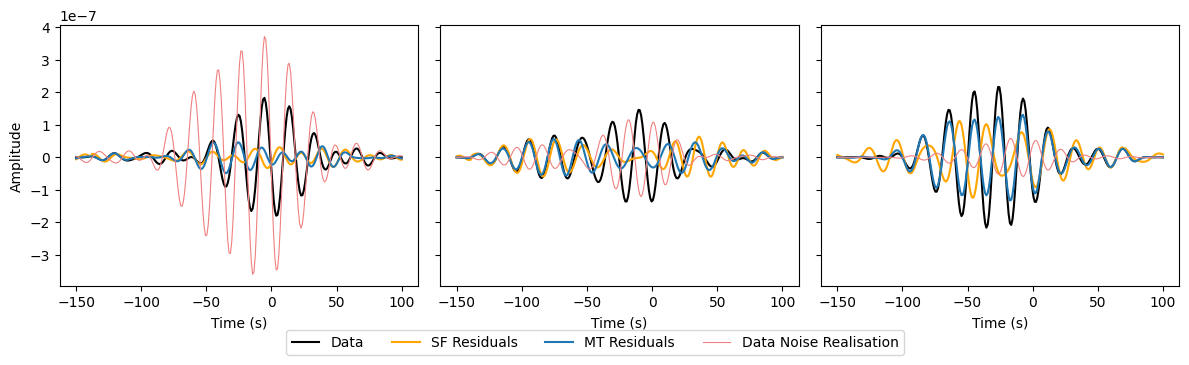

In [51]:
fig_height = 3.5  # Adjust scaling as needed
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True, sharey=True)
noise_stat,noise_realization = 0,6

cdset = [cdset[0][1][0], cdset[0][1][1], cdset[0][1][2]] #  cdset[0][1][0] if comp == 'Z' else cdset[0][1][1] if comp == 'R' else cdset[0][1][2]), c='darkgrey', label='ML Data Covariance')

# noise = [low_amps_z,low_amps_r,low_amps_t]
#cdn = [cd_z,cd_r,cd_t]
# res = [res_z,res_r,res_t]
for i in range(1):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, ydatas[0][:, j], c='k', label='Data')
        #ax.plot(time, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
        # ax.plot(time,res[j][0],c='k',lw=0.5)
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='tab:blue', label='MT Residuals')
        # ax.plot(test_checker_x, residualss_son[i][j], c='c', ls='--', label='Son et al. 2025 Residuals')
        ax.plot(test_checker_x,np.random.multivariate_normal(np.zeros(250),cdset[j]),c='lightcoral', lw=0.8, label='Data Noise Realisation')
        if j == 0:
            ax.set_ylabel(f'Amplitude')
        ax.set_xlabel('Time (s)')
        # ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
        
# Get handles and labels from one of the axes (they should all be the same)
handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.suptitle('Synthetic Unrealistic Noise Random Noise Realization', fontsize=14)
plt.tight_layout()

fig.savefig('PIG_2_singlestation_noise.svg', bbox_inches='tight')
plt.show()